In [1]:
'''
author: Yike Xie
data: 22/2/2023
content: correlate image features and exon transcriptome
'''

'\nauthor: Yike Xie\ndata: 22/2/2023\ncontent: correlate image features and exon transcriptome\n'

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)
    
    print('filter single cells')
    adata = adata[adata.obs['doublets'] != 'Yes']

#     print('filter genes')
#     sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

In [4]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/bkg_sub_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/exon_filter.h5ad'
adata = sig_dataset(feas_fn, data_fn)
# exclude exons corresponding to unknown genes
adata = adata[:, adata.var['gene_name'] != '']

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/exon/'

load features
load dataset
filter single cells


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.obs` of view, copying.


Add features to adata


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [5]:
# expression of exon numbers
if False:
    adata_g = adata.copy()
    adata_g.var = adata_g.var.reset_index().set_index(['gene_name', 'exon_number'])

    idx = np.unique(adata_g.var_names)
    exon_number_exp = pd.DataFrame(columns=adata_g.obs_names)
    exon_number_exp['gene_name'] = [i[0] for i in idx]
    exon_number_exp['exon_number'] = [i[1] for i in idx]
    exon_number_exp = exon_number_exp.set_index(['gene_name', 'exon_number'])

    for exon_n in exon_number_exp.index:
        exon_number_exp.loc[exon_n] = adata_g[:, adata_g.var_names == exon_n].X.sum(axis=1)

    save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/exon/'
    exon_number_exp.to_csv(save_figures + 'exon_number_exp.tsv', sep='\t')

# expression of genes
if False:
    adata_g2 = adata.copy()
    adata_g2.var = adata_g2.var.reset_index().set_index(['gene_name'])

    idx = np.unique(adata_g2.var_names)
    gene_exp = pd.DataFrame(columns=adata_g2.obs_names)
    gene_exp['gene_name'] = idx
    gene_exp = gene_exp.set_index('gene_name')

    for gene in gene_exp.index:
        gene_exp.loc[gene] = adata_g2[:, adata_g2.var_names == gene].X.sum(axis=1)

    save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/exon/'
    gene_exp.to_csv(save_figures + 'gene_exp.tsv', sep='\t')

if False:
    # compute fractions of exon numbers
    exon_number_exp = pd.read_csv(save_figures + 'exon_number_exp.tsv', 
                                  sep='\t', index_col=['gene_name', 'exon_number'])
    gene_exp = pd.read_csv(save_figures + 'gene_exp.tsv', sep='\t', index_col='gene_name')

    exon_number_frac = exon_number_exp.values / gene_exp.loc[[i[0] for i in exon_number_exp.index]].values
    exon_number_frac = pd.DataFrame(exon_number_frac, index=exon_number_exp.index, 
                                    columns=exon_number_exp.columns)

    exon_number_frac['Number'] = (exon_number_exp.values > 0).sum(axis=1)
    exon_number_frac['Frac'] = (exon_number_exp.values > 0).sum(axis=1) / exon_number_exp.shape[1]

    exon_number_frac.to_csv(save_figures + 'exon_number_frac.tsv', sep='\t')

In [7]:
exon_number_exp = pd.read_csv(save_figures + 'exon_number_exp.tsv', 
                              sep='\t', index_col=['gene_name', 'exon_number'])
gene_exp = pd.read_csv(save_figures + 'gene_exp.tsv', sep='\t', index_col='gene_name')
exon_number_frac = pd.read_csv(save_figures + 'exon_number_frac.tsv', 
                               sep='\t', index_col=['gene_name', 'exon_number'])

In [8]:
if False:
    # number of cells expressing a gene more than exp_threshold 
    
    # expression reads: 10
    exp_threshold = 10
    cells_by_gene = {}
    for gene in exon_number_exp.index.get_level_values(0).unique():
        cells_by_gene[gene] = exon_number_exp.columns[exon_number_exp.loc[gene].sum(axis=0) >= exp_threshold]
    ncells_by_gene = {key: len(val) for key, val in cells_by_gene.items()}

    # number of genes expressed by more than 70 cells
    a = pd.Series(ncells_by_gene)
    a.sort_values(ascending=False, inplace=True)
    (a >= 70).mean() * 20000

    # cumulative plot
    x = np.sort(list(ncells_by_gene.values()))
    y = 1.0 - np.linspace(0, 1, len(x))
    plt.plot(x, y)

In [12]:
# genes that are not expressed by any cell
no_exp_genes = gene_exp[gene_exp.sum(axis=1) == 0].index

# genes with only one exon
gene_1exon = [gene for gene in exon_number_exp.index.get_level_values(0) 
                 if (exon_number_exp.loc[gene].sum(axis=1) > 0).sum() == 1]

# excluded genes in total
excld_genes = list(set(no_exp_genes) | set(gene_1exon))

# exclud these genes in exon_number_frac
exon_number_frac = exon_number_frac.drop(excld_genes)

In [13]:
def spearman_nD(x, y):
    '''
    x: (39466, 10) number of genes, number of cells
    y: (2, 10) number of features, number of cells
    
    '''
    from scipy.stats import rankdata
    xw = np.zeros(x.shape, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros(y.shape, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n
    
    return r

In [14]:
exp_threshold = 10

feas = ['area']
phe = adata.obs[feas]
exon_fracs = exon_number_frac[exon_number_frac.columns[:-2]]

res = pd.DataFrame()
for gene in exon_fracs.index.get_level_values(0).unique():
    g_idx = (gene_exp.loc[gene] >= exp_threshold) 
    
    x = exon_fracs.loc[gene][g_idx.index[g_idx]]
    y = phe[g_idx]
    r = spearman_nD(x.values, y.values.T)
    
    corr = pd.DataFrame(
                data=r,
                columns=phe.columns,
                dtype=float)

    corr['gene_name'] = gene
    corr['exon_number'] = exon_fracs.loc[gene].index
    corr['n_cell_gene'] = g_idx.sum()
    
    res = pd.concat([res, corr])
    
res.to_csv(save_figures + 'corr_area_exon_usage_omit_na_exp10.tsv', sep='\t')

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <=

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
 

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_met

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret =

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <=

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/hom

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/hom

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <=

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/hom

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/hom

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <=

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret =

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/hom

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
 

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <=

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret =

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <=

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
 

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:18: RuntimeWarning: invalid value encountered in true_divide
  r = np.dot(xw, yw.T) / n
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarni

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret =

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_met

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <=

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <=

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret =

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_met

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
 

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/hom

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
 

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
 

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/hom

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <=

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-13-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ip

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-13-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)

## plot the example of alternative splicing

In [24]:
number_fra = pd.read_csv(save_figures + 'exon_number_frac.tsv', 
                         sep='\t', index_col=['gene_name', 'exon_number'])

In [19]:
res.set_index(['gene_name', 'exon_number'], inplace=True)

In [31]:
res.loc['SLC38A2']

,area,n_cell_gene
exon_number,,
1,-0.072927,84
10,0.217568,84
11,0.197201,84
12,0.278462,84
13,0.190050,84
15,0.331689,84
16,0.344844,84
2,-0.199930,84
3,-0.368578,84


In [27]:
def plot_bin_exons(number_fra, gene, exon_ns, bin_n, cmaps, filetype, path=False):
    # create dataframe
    area_order = adata.obs['area'].sort_values().index
    df = number_fra.loc[gene].loc[exon_ns].T.loc[area_order] * 100
    df['order'] = '0'
    for i in range(bin_n):
        n = round(df.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < df.shape[0]]
        df.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    # plot boxplots
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    fig, axs = plt.subplots(1, len(exon_ns), figsize=[0.5 + 2 * len(exon_ns), 3], sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.05)
    
    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
        
    name = gene
    for i, (n, cmap) in enumerate(zip(exon_ns, cmaps)):

        med = [df[df['order'] == 'Group {}'.format(str(i + 1))][n].median()
           for i in range(bin_n)]
        alpha = [0.2 + 0.6 * i/max(med) for i in med]
        cmap = mpl.cm.get_cmap(cmap)
        palette = [cmap(i) for i in alpha]

        sns.boxplot(data=df, x='order', y=n, palette=palette, ax=axs[i], **PROPS)
        sns.stripplot(data=df, x='order', y=n, palette=palette, edgecolor='white', linewidth=1, ax=axs[i], size=3)
        axs[i].set_xticks([])
        axs[i].set_xticklabels([])
        axs[i].set_xlabel(None)
        axs[i].set_ylabel(None)
        axs[i].set_title('{}: exon {}'.format(gene, str(n)))
        
        name += str(n)
        
    fig.text(0.5, 0.05, '{} of cells: smallest → largest'.format(fea.title()), va='center', ha='center')
    fig.text(0.05, 0.5, 'Frac of exon exp/gene exp [%]', va='center', ha='center', rotation=90)

    if path is not False:
        fig.savefig(os.path.join(path, name+filetype), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'axs': axs}

{'fig': <Figure size 468x216 with 3 Axes>,
 'axs': array([<AxesSubplot: title={'center': 'SLC38A2: exon 4'}>,
        <AxesSubplot: title={'center': 'SLC38A2: exon 1'}>,
        <AxesSubplot: title={'center': 'SLC38A2: exon 15'}>], dtype=object)}

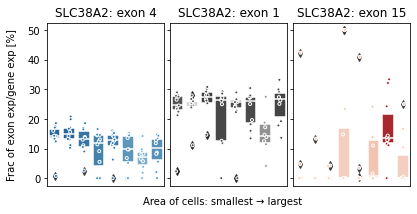

In [33]:
fea = 'area'
gene = 'SLC38A2'
exon_ns = [4, 1, 15]
bin_n = 8
cmaps = ['Blues', 'Greys', 'Reds']
path = save_figures

plot_bin_exons(number_fra, gene, exon_ns, bin_n, cmaps, '.png', path=False)
# plot_bin_exons(number_fra, gene, exon_ns, bin_n, cmaps, '.pdf', path)